<a href="https://colab.research.google.com/github/suryawahyus/MachineLearning/blob/main/UAS/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 34.06 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a5a88f10f10>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

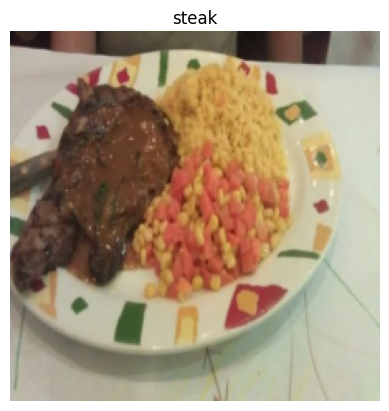

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [10]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model()
# effnetb2
effnetb2_transforms

In [13]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Create dataloaders for EffNetB2
from going_modular.going_modular import data_setup

BATCH_SIZE = 32
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=BATCH_SIZE)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

In [ ]:
# Train EffNetB2 feature extractor
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

In [ ]:

from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [ ]:
# Create another ViT feature model instance
vit_food101_20_percent, vit_transforms = create_vit_model(num_classes=101)

# Print ViT model summary (uncomment for full output)
from torchinfo import summary
summary(vit_food101_20_percent,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [ ]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms,
])

food101_train_transforms

In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_transforms, # perform normal ViT transforms on test data
                             download=True)

In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]


## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [ ]:
# Loop through test DataLoader (with batch size 1)
# Make prediction with model
# Store prediction and prediction probability to dictionary
# Append dictionary to list
# Inspect list

# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_batch_size_1 = DataLoader(test_data_food101_20_percent,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  num_workers=NUM_WORKERS)

# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_pred_list = []
for X, y in tqdm(test_dataloader_food101_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_pred_list.append(pred_dict)

In [ ]:
food101_class_names[:5]

In [ ]:
# Create DataFrame with various columns
pred_df_20_percent = pd.DataFrame(vit_food101_pred_list)

# Create a column for if the prediction is correct
pred_df_20_percent["is_correct"] = pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]

# Create class name columns (e.g. pred_label=72 -> pred_class="pancakes")
pred_df_20_percent["pred_class"] = pred_df_20_percent["pred_label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent["label_class"] = pred_df_20_percent["label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent.head()

In [ ]:
# Get top 10 samples that are "most wrong", e.g. highest pred_prob but wrong prediction - why??
pred_df_20_percent[pred_df_20_percent["is_correct"] == False].sort_values("pred_prob", ascending=False)[:10]

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [ ]:
# Check length of Food101 test data
len(test_data)

In [ ]:
# Turn Food101 test data into DataLoader
# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_all_data_batch_size_1 = DataLoader(test_data,
                                                           batch_size=1,
                                                           shuffle=False,
                                                           num_workers=NUM_WORKERS)

len(test_dataloader_food101_all_data_batch_size_1)

In [ ]:
# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_all_test_data_pred_list = []
for X, y in tqdm(test_dataloader_food101_all_data_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_all_test_data_pred_list.append(pred_dict)


In [ ]:
# Evalaute model on entire test set
food101_all_test_data_df = pd.DataFrame(vit_food101_all_test_data_pred_list)
food101_all_test_data_df["is_correct"] = food101_all_test_data_df["pred_label"] == food101_all_test_data_df["label"]
food101_all_test_data_df.is_correct.value_counts()

In [ ]:
# Calculate accuracy across Food101 all test
print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[1]